A multi-modal sensor dataset for continuous stress detection of nurses in a hospital
Hosseini, Seyedmajid1; Katragadda, Satya1; Bhupatiraju, Ravi Teja1; Ashkar, Ziad1; Borst, Christoph1; Cochran, Kenneth1; Gottumukkala, Raju1

https://www.nature.com/articles/s41597-022-01361-y/tables/5

In [1]:
import zipfile
import os

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import scipy.signal as scisig
import scipy.stats

from utilities.stress_feature_extractors import decompose_signal

%load_ext autoreload
%autoreload 2

In [2]:
dirs = os.listdir('./data/Hosseini_Stress_Dataset/')[:-1]
dirs

['15',
 '5C',
 '6B',
 '6D',
 '7A',
 '7E',
 '83',
 '8B',
 '94',
 'BG',
 'CE',
 'DF',
 'E4',
 'EG',
 'F5']

In [461]:
# # Extract data from zip file
# for dir in dirs:
#     for index, file in enumerate(os.listdir(f'./data/Hosseini_Stress_Dataset/{dir}/')):
#         with zipfile.ZipFile(f'./data/Hosseini_Stress_Dataset/{dir}/{file}', 'r') as zip_ref:
#             os.makedirs(f'./data/Hosseini_Stress_Dataset/{dir}/{index}')
#             zip_ref.extract('EDA.csv', path=f'./data/Hosseini_Stress_Dataset/{dir}/{index}')

In [462]:
# # delete zip files
# for dir in dirs:
#     zip_files = os.listdir(f'./data/Hosseini_Stress_Dataset/{dir}/')
#     filt_zip_files = list(filter(lambda zip_file: ".zip" in zip_file, zip_files))
#     print(filt_zip_files)
#     for index, file in enumerate(filt_zip_files):
#         os.remove(f'./data/Hosseini_Stress_Dataset/{dir}/{file}')

#### read each file in each subjects subfolder i.e. 5C has subfolders 0 to 25 containing `EDA.csv`, convert its header to a readable timedelta format as well as total seconds or timestmap as this indicates it in the excel spreadsheet file

In [ ]:
survey_results = pd.read_excel('./data/Hosseini_Stress_Dataset/SurveyResults.xlsx', index_col=0)
survey_results.reset_index(inplace=True)
survey_results


The number 1586886626.000000 is a Unix timestamp, which represents the number of seconds that have elapsed since January 1, 1970, 00:00:00 UTC.

To convert this timestamp to a human-readable format like HH:MM:SS, you can use the following methods:

1. Using the datetime module:

Python
```
import datetime

timestamp = 1586886626.000000
dt = datetime.datetime.fromtimestamp(timestamp)
formatted_time = dt.strftime('%H:%M:%S')
print(formatted_time)  # Output: 14:37:06
```
Use code with caution.

2. Using the time module:

Python
```
import time

timestamp = 1586886626.000000
formatted_time = time.strftime('%H:%M:%S', time.localtime(timestamp))
print(formatted_time)  # Output: 14:37:06
```
Use code with caution.

Both methods will output the time in the format HH:MM:SS, where HH is the hour, MM is the minute, and SS is the second.

If you need to convert the time to a different time zone, you can use the timezone argument of the datetime.datetime.fromtimestamp() function.

In [ ]:
# remove rows in survey_results with na in stress level
survey_results_cleaned = survey_results[survey_results['Stress level'] != 'na'].reset_index(drop=True)
survey_results_cleaned = survey_results_cleaned[['ID', 'Start time', 'End time', 'duration', 'date', 'Stress level']]
survey_results_cleaned

the date column contains information e.g.
we can check
YY:MM:DD HH:MM:SS
2020-04-15 08:00:00 is the start time and 
2020-04-15 09:00:00 is the end time of one patients recording session

In [466]:
subjects = {
    # '5C': [
    #     (timestamp, df), 
    #     (timestamp, df),
    #     ...
    #     (timestamp, df),
    # ],
    # '6B': [
    #     (timestamp, df), 
    #     (timestamp, df),
    #     ...
    #     (timestamp, df),
    # ],
    # ...
    # 'EG': [
    #     (timestamp, df), 
    #     (timestamp, df),
    #     ...
    #     (timestamp, df),
    # ]
}

# read csvs first
for dir in dirs:

    subject_dfs = []
    for subdir in os.listdir(f'./data/Hosseini_Stress_Dataset/{dir}/'):
        df = pd.read_csv(f'./data/Hosseini_Stress_Dataset/{dir}/{subdir}/EDA.csv', )
        start_epoch_header = df.columns[0]

        # calculate also phasic and tonic component of raw signal
        tonic, phasic = decompose_signal(df[start_epoch_header], samp_freq=4, method="median")
        df['phasic'] = phasic
        df['tonic'] = tonic

        # retrieve timestamp string from column
        timestamp = float(start_epoch_header)

        # modify header of raw signal
        df.rename(columns={start_epoch_header: 'raw_signal'}, inplace=True)

        # so according to hosseini et al. (2022) the header is actually the 
        # time that signal was generated using the internal clock of the wristband. 
        # The DateTime is stored in the first row of every data column.
        # this is the starttime
        subject_dfs.append((timestamp, df))

    subjects[dir] = subject_dfs

In [ ]:
subjects['15']

In [468]:

from datetime import datetime as dt

def time_in_seconds(date_time):
    epoch = dt.utcfromtimestamp(0)
    delta = date_time - epoch
    return delta.total_seconds()

def helper(row):
    
    start_time = row['Start time'].strftime('%H:%M')
    end_time = row['End time'].strftime('%H:%M')
    date = row['date'].strftime('%Y-%m-%d')
    duration = row['duration']
    subject = str(row['ID'])
    print(f'current subject: {subject}')

    # print(type(start_time))

    start_timestamp = dt.strptime(f'{date} {start_time}', '%Y-%m-%d %H:%M')
    end_timestamp = dt.strptime(f'{date} {end_time}', '%Y-%m-%d %H:%M')
    start_timestamp_s = time_in_seconds(start_timestamp)
    end_timestamp_s = time_in_seconds(end_timestamp)
    # 1594140175.0
    # 1586937600.0
    # print(f'start timestamp in seconds {start_timestamp_s}')
    # print(f'end timestamp in seconds {end_timestamp_s}')

    for index, (timestamp, df) in enumerate(subjects[subject]):
        flag = start_timestamp_s <= timestamp <= end_timestamp_s
        if flag == True:
            print(f'start time: {start_timestamp}')
            print(f'start time seconds: {start_timestamp_s} {timestamp} for subject: {subject}')
            df['label'] = row['Stress level']

In [ ]:
subjects.keys()

In [ ]:
survey_results_cleaned.apply(helper, axis=1)

In [471]:
new_subjects = {}

In [ ]:
for subject, records in subjects.items():

    new_subject_dfs = []
    for record in records:
        if 'label' in record[1].columns:
            print(f'subject: {subject}')
            print(f'record: {record}')

            new_subject_dfs.append(record)
        
    new_subjects[subject] = new_subject_dfs            

but how can I know if this timestamp matches the times in my excel sheet? Because I do have information of the start time and end time of my actually eda signals. E.g. YY:MM:DD HH:MM:SS

2020-04-15 08:00:00 is the start time and 

2020-04-15 09:00:00 is the end time of one patients recording session

calculated timedelta or its duration was 01:00:00. How can I leverage this information to map this timedelta to this start time and end time and duration

To determine if a timestamp matches the time range specified in your Excel sheet, you can follow these steps:

Convert Excel time to Unix timestamp:

Convert the start and end times from your Excel sheet to Unix timestamps using a library like openpyxl or pandas.
You can use the datetime.datetime.strptime() function to parse the time strings and convert them to datetime objects, then use the timestamp() method to get the Unix timestamp.
Compare timestamps:

Check if the given timestamp (1586886626.000000) falls within the range of the start and end timestamps from your Excel sheet.
Here's an example using pandas:

Python
import pandas as pd
```
# Assuming you have an Excel file with columns 'start_time' and 'end_time'
df = pd.read_excel('your_excel_file.xlsx')

# Convert start and end times to Unix timestamps
df['start_time_unix'] = pd.to_datetime(df['start_time']).astype(int) // 10**9
df['end_time_unix'] = pd.to_datetime(df['end_time']).astype(int) // 10**9

# Check if the given timestamp falls within the range
timestamp = 1586886626.000000
is_within_range = (df['start_time_unix'] <= timestamp) & (df['end_time_unix'] >= timestamp)

if is_within_range.any():
    print("The timestamp falls within the recorded time range.")
else:
    print("The timestamp is outside the recorded time range.")
```
Use code with caution.

This code will read the Excel file, convert the start and end times to Unix timestamps, and check if the given timestamp falls within any of the recorded time ranges. You can then use the information from the DataFrame to map the timestamp to the corresponding row and extract other relevant data.

In [ ]:
new_subjects

In [ ]:
for new_subject, records in new_subjects.items():
    print(len(records))

In [ ]:
data_for_vis = new_subjects['15'][0][1]
data_for_vis

In [476]:
begin_time = 0
end_time = round((data_for_vis.shape[0] - 1) / 4 )

In [ ]:
end_time

In [32]:
def view_time_frame(raw_eda_df, samp_freq=128, begin_time_s=1750, end_time_s=1765, cols_to_use=['rawdata', 'cleandata', 'signal_automatic'], save_img=True, img_title='untitled'):
    """
    ntoe cols to use must be equal to 5 or more
    """
    fig = plt.figure(figsize=(17, 5))

    axis = fig.add_subplot()


    # why is it multiplied by 128?
    # results it 224000 and 225920 and is used as indeces to access a slice of the dataframes rows
    begin_sample, end_sample = begin_time_s * samp_freq, end_time_s * samp_freq
    print(begin_sample, end_sample)

    # 
    time_to_plot = np.arange(begin_sample, end_sample)
    

    # colors and linestyles to use
    colors = ['#2cb88e', '#c21d5c', '#d16d15', '#fc8003', '#3dfc03']
    lines = ['solid', 'dotted', 'dashed', 'dashdot', (5, (10, 3))]

    for i, col in enumerate(cols_to_use):
        
        col_to_plot = raw_eda_df[col].iloc[begin_sample:end_sample]
        print(time_to_plot)
        print(col_to_plot)
        axis.plot(time_to_plot, col_to_plot, label=col, alpha=0.75, linestyle=lines[i], c=colors[i])
            
    axis.legend(fontsize=14)
    axis.grid()
    
    axis.set_title(f"{img_title}")
    axis.set_ylabel(r'$\mu S$', fontsize=16)
    axis.set_xlabel("Time (s)", fontsize=16)

    if save_img:
        plt.savefig(f'./figures & images/{img_title}.png')
        plt.show()

In [ ]:
view_time_frame(data_for_vis, samp_freq=4, begin_time_s=begin_time, end_time_s=end_time, cols_to_use=['raw_signal'])

In [ ]:
view_time_frame(data_for_vis, samp_freq=4, begin_time_s=begin_time, end_time_s=end_time, cols_to_use=['phasic'])

In [481]:
# we have 
hertz = 4
window_size = 5
samples_per_sec = hertz

In [482]:
test_subjects = {
    '15': new_subjects['15'],
    '5C': new_subjects['5C']
}

In [ ]:
test_subjects

In [ ]:
new_subjects['15'][0][1]['phasic'].value_counts()

In [33]:
from utilities.stress_feature_extractors import *

In [ ]:
results = get_features(new_subjects, hertz, window_size)
results

## notee taht labels 0, 1, and 2 represent abseline, medium, and high stress levels respectively

In [ ]:
len(results['15'])

# Export features_and_labels dataframe of each subject to .csv

In [487]:
for subject, dfs in results.items():
    for i, df in enumerate(dfs):
        df.to_csv(f'./data/Stress Detection Features/train/{subject}_{i}.csv')

In [7]:
from utilities.loaders import save_lookup_array, load_lookup_array, load_model, save_model

In [8]:
dirs

['15',
 '5C',
 '6B',
 '6D',
 '7A',
 '7E',
 '83',
 '8B',
 '94',
 'BG',
 'CE',
 'DF',
 'E4',
 'EG',
 'F5']

In [7]:
save_lookup_array('./data/Stress Detection Features/subjects.txt', dirs)

# Training phase

In [9]:
subject_names = load_lookup_array('./data/Stress Detection Features/subjects.txt')
subject_names

['15',
 '5C',
 '6B',
 '6D',
 '7A',
 '7E',
 '83',
 '8B',
 '94',
 'BG',
 'CE',
 'DF',
 'E4',
 'EG',
 'F5']

In [11]:
# load dataframes into a list
# remove rows with nans
temp = []
for file in os.listdir('./data/Stress Detection Features/train'):
    # subject, df_index = file.split('_')
    df = pd.read_csv(f'./data/Stress Detection Features/train/{file}', index_col=0)
    temp.append(df)
subjects_features_and_labels = pd.concat(temp, axis=0, ignore_index=True)

In [12]:
temp

[      raw_4hz_max  raw_4hz_min  raw_4hz_amp  raw_4hz_median  raw_4hz_std  \
 0        4.000000     0.000000     0.461509        0.192840     0.843004   
 1        0.474092     0.202450     0.269592        0.251782     0.066068   
 2        0.377993     0.169136     0.296628        0.338912     0.073927   
 3        0.440778     0.156322     0.270873        0.212701     0.106277   
 4        0.269080     0.000000     0.117690        0.121085     0.086402   
 ...           ...          ...          ...             ...          ...   
 1152     0.210138     0.197325     0.205718        0.205653     0.003098   
 1153     0.202450     0.093537     0.169328        0.181308     0.033320   
 1154     0.197325     0.155041     0.174325        0.171699     0.011414   
 1155     0.299831     0.129414     0.174773        0.147353     0.053546   
 1156     0.265236     0.140946     0.194879        0.181949     0.037737   
 
       raw_4hz_range  raw_4hz_shannon_entropy  raw_4hz_1d_max  raw_4hz_1d_

In [13]:
subjects_features_and_labels

,raw_4hz_max,raw_4hz_min,raw_4hz_amp,raw_4hz_median,raw_4hz_std,raw_4hz_range,raw_4hz_shannon_entropy,raw_4hz_1d_max,raw_4hz_1d_min,raw_4hz_1d_amp,...,phasic_4hz_2d_std,phasic_4hz_2d_range,phasic_4hz_2d_shannon_entropy,phasic_4hz_2d_max_abs,phasic_4hz_2d_avg_abs,raw_4hz_skewness,raw_4hz_kurt,phasic_4hz_skewness,phasic_4hz_kurt,label
0,4.000000,0.000000,0.461509,0.192840,0.843004,4.000000,2.995732,0.365820,0.005259,0.150149,...,0.0,0.0,0.0,0.0,0.062686,3.653597,12.543503,1.119450,1.646600,2
1,0.474092,0.202450,0.269592,0.251782,0.066068,0.271642,2.995732,0.237046,0.101225,0.136181,...,0.0,0.0,0.0,0.0,0.027158,1.960686,3.102000,1.330427,1.255031,2
2,0.377993,0.169136,0.296628,0.338912,0.073927,0.208857,2.926418,0.188997,0.084568,0.158324,...,0.0,0.0,0.0,0.0,0.020907,-0.605916,-1.269754,-0.330210,-1.372222,2
3,0.440778,0.156322,0.270873,0.212701,0.106277,0.284456,2.926418,0.220389,0.078161,0.142148,...,0.0,0.0,0.0,0.0,0.040767,0.436781,-1.540076,0.256945,-1.399050,2
4,0.269080,0.000000,0.117690,0.121085,0.086402,0.269080,2.761626,0.134540,0.000000,0.061464,...,0.0,0.0,0.0,0.0,0.042845,0.102103,-1.211509,0.109781,-0.884316,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44115,0.316565,0.266623,0.289673,0.289033,0.010652,0.049942,2.415052,0.158282,0.133311,0.144917,...,0.0,0.0,0.0,0.0,0.004544,0.138091,1.438830,0.351473,0.511257,2
44116,0.322968,0.274307,0.293963,0.292234,0.016470,0.048661,2.718473,0.161484,0.137154,0.145557,...,0.0,0.0,0.0,0.0,0.007443,0.409886,-1.279887,0.161440,-0.826752,2
44117,0.333212,0.289673,0.307921,0.306321,0.012012,0.043539,2.579844,0.166606,0.145477,0.153961,...,0.0,0.0,0.0,0.0,0.004347,0.798481,0.063998,0.378197,-0.479223,2
44118,0.395960,0.281990,0.342432,0.338334,0.037124,0.113970,2.926418,0.197980,0.140995,0.172529,...,0.0,0.0,0.0,0.0,0.009882,-0.050607,-1.410645,0.237736,-0.510311,2


In [14]:
subjects_features_and_labels.isnull().sum()

raw_4hz_max                          0
raw_4hz_min                          0
raw_4hz_amp                          0
raw_4hz_median                       0
raw_4hz_std                          0
raw_4hz_range                        0
raw_4hz_shannon_entropy              0
raw_4hz_1d_max                       9
raw_4hz_1d_min                       9
raw_4hz_1d_amp                       9
raw_4hz_1d_median                44120
raw_4hz_1d_std                       9
raw_4hz_1d_range                     9
raw_4hz_1d_shannon_entropy           0
raw_4hz_1d_max_abs                   9
raw_4hz_1d_avg_abs                   9
raw_4hz_2d_max                       9
raw_4hz_2d_min                       9
raw_4hz_2d_amp                       9
raw_4hz_2d_median                44120
raw_4hz_2d_std                       9
raw_4hz_2d_range                     9
raw_4hz_2d_shannon_entropy           0
raw_4hz_2d_max_abs                   9
raw_4hz_2d_avg_abs                   9
phasic_4hz_max           

In [15]:
cols_to_remove = ['raw_4hz_1d_median',
'raw_4hz_2d_median',
'phasic_4hz_1d_median',
'phasic_4hz_2d_median',]

In [16]:
subjects_features_and_labels.columns

Index(['raw_4hz_max', 'raw_4hz_min', 'raw_4hz_amp', 'raw_4hz_median',
       'raw_4hz_std', 'raw_4hz_range', 'raw_4hz_shannon_entropy',
       'raw_4hz_1d_max', 'raw_4hz_1d_min', 'raw_4hz_1d_amp',
       'raw_4hz_1d_median', 'raw_4hz_1d_std', 'raw_4hz_1d_range',
       'raw_4hz_1d_shannon_entropy', 'raw_4hz_1d_max_abs',
       'raw_4hz_1d_avg_abs', 'raw_4hz_2d_max', 'raw_4hz_2d_min',
       'raw_4hz_2d_amp', 'raw_4hz_2d_median', 'raw_4hz_2d_std',
       'raw_4hz_2d_range', 'raw_4hz_2d_shannon_entropy', 'raw_4hz_2d_max_abs',
       'raw_4hz_2d_avg_abs', 'phasic_4hz_max', 'phasic_4hz_min',
       'phasic_4hz_amp', 'phasic_4hz_median', 'phasic_4hz_std',
       'phasic_4hz_range', 'phasic_4hz_shannon_entropy', 'phasic_4hz_1d_max',
       'phasic_4hz_1d_min', 'phasic_4hz_1d_amp', 'phasic_4hz_1d_median',
       'phasic_4hz_1d_std', 'phasic_4hz_1d_range',
       'phasic_4hz_1d_shannon_entropy', 'phasic_4hz_1d_max_abs',
       'phasic_4hz_1d_avg_abs', 'phasic_4hz_2d_max', 'phasic_4hz_2d_min',


In [17]:
subjects_features_and_labels = subjects_features_and_labels.drop(columns=cols_to_remove)
subjects_features_and_labels

,raw_4hz_max,raw_4hz_min,raw_4hz_amp,raw_4hz_median,raw_4hz_std,raw_4hz_range,raw_4hz_shannon_entropy,raw_4hz_1d_max,raw_4hz_1d_min,raw_4hz_1d_amp,...,phasic_4hz_2d_std,phasic_4hz_2d_range,phasic_4hz_2d_shannon_entropy,phasic_4hz_2d_max_abs,phasic_4hz_2d_avg_abs,raw_4hz_skewness,raw_4hz_kurt,phasic_4hz_skewness,phasic_4hz_kurt,label
0,4.000000,0.000000,0.461509,0.192840,0.843004,4.000000,2.995732,0.365820,0.005259,0.150149,...,0.0,0.0,0.0,0.0,0.062686,3.653597,12.543503,1.119450,1.646600,2
1,0.474092,0.202450,0.269592,0.251782,0.066068,0.271642,2.995732,0.237046,0.101225,0.136181,...,0.0,0.0,0.0,0.0,0.027158,1.960686,3.102000,1.330427,1.255031,2
2,0.377993,0.169136,0.296628,0.338912,0.073927,0.208857,2.926418,0.188997,0.084568,0.158324,...,0.0,0.0,0.0,0.0,0.020907,-0.605916,-1.269754,-0.330210,-1.372222,2
3,0.440778,0.156322,0.270873,0.212701,0.106277,0.284456,2.926418,0.220389,0.078161,0.142148,...,0.0,0.0,0.0,0.0,0.040767,0.436781,-1.540076,0.256945,-1.399050,2
4,0.269080,0.000000,0.117690,0.121085,0.086402,0.269080,2.761626,0.134540,0.000000,0.061464,...,0.0,0.0,0.0,0.0,0.042845,0.102103,-1.211509,0.109781,-0.884316,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44115,0.316565,0.266623,0.289673,0.289033,0.010652,0.049942,2.415052,0.158282,0.133311,0.144917,...,0.0,0.0,0.0,0.0,0.004544,0.138091,1.438830,0.351473,0.511257,2
44116,0.322968,0.274307,0.293963,0.292234,0.016470,0.048661,2.718473,0.161484,0.137154,0.145557,...,0.0,0.0,0.0,0.0,0.007443,0.409886,-1.279887,0.161440,-0.826752,2
44117,0.333212,0.289673,0.307921,0.306321,0.012012,0.043539,2.579844,0.166606,0.145477,0.153961,...,0.0,0.0,0.0,0.0,0.004347,0.798481,0.063998,0.378197,-0.479223,2
44118,0.395960,0.281990,0.342432,0.338334,0.037124,0.113970,2.926418,0.197980,0.140995,0.172529,...,0.0,0.0,0.0,0.0,0.009882,-0.050607,-1.410645,0.237736,-0.510311,2


In [18]:
subjects_features_and_labels = subjects_features_and_labels.dropna()
subjects_features_and_labels

,raw_4hz_max,raw_4hz_min,raw_4hz_amp,raw_4hz_median,raw_4hz_std,raw_4hz_range,raw_4hz_shannon_entropy,raw_4hz_1d_max,raw_4hz_1d_min,raw_4hz_1d_amp,...,phasic_4hz_2d_std,phasic_4hz_2d_range,phasic_4hz_2d_shannon_entropy,phasic_4hz_2d_max_abs,phasic_4hz_2d_avg_abs,raw_4hz_skewness,raw_4hz_kurt,phasic_4hz_skewness,phasic_4hz_kurt,label
0,4.000000,0.000000,0.461509,0.192840,0.843004,4.000000,2.995732,0.365820,0.005259,0.150149,...,0.0,0.0,0.0,0.0,0.062686,3.653597,12.543503,1.119450,1.646600,2
1,0.474092,0.202450,0.269592,0.251782,0.066068,0.271642,2.995732,0.237046,0.101225,0.136181,...,0.0,0.0,0.0,0.0,0.027158,1.960686,3.102000,1.330427,1.255031,2
2,0.377993,0.169136,0.296628,0.338912,0.073927,0.208857,2.926418,0.188997,0.084568,0.158324,...,0.0,0.0,0.0,0.0,0.020907,-0.605916,-1.269754,-0.330210,-1.372222,2
3,0.440778,0.156322,0.270873,0.212701,0.106277,0.284456,2.926418,0.220389,0.078161,0.142148,...,0.0,0.0,0.0,0.0,0.040767,0.436781,-1.540076,0.256945,-1.399050,2
4,0.269080,0.000000,0.117690,0.121085,0.086402,0.269080,2.761626,0.134540,0.000000,0.061464,...,0.0,0.0,0.0,0.0,0.042845,0.102103,-1.211509,0.109781,-0.884316,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44115,0.316565,0.266623,0.289673,0.289033,0.010652,0.049942,2.415052,0.158282,0.133311,0.144917,...,0.0,0.0,0.0,0.0,0.004544,0.138091,1.438830,0.351473,0.511257,2
44116,0.322968,0.274307,0.293963,0.292234,0.016470,0.048661,2.718473,0.161484,0.137154,0.145557,...,0.0,0.0,0.0,0.0,0.007443,0.409886,-1.279887,0.161440,-0.826752,2
44117,0.333212,0.289673,0.307921,0.306321,0.012012,0.043539,2.579844,0.166606,0.145477,0.153961,...,0.0,0.0,0.0,0.0,0.004347,0.798481,0.063998,0.378197,-0.479223,2
44118,0.395960,0.281990,0.342432,0.338334,0.037124,0.113970,2.926418,0.197980,0.140995,0.172529,...,0.0,0.0,0.0,0.0,0.009882,-0.050607,-1.410645,0.237736,-0.510311,2


In [19]:
subjects_features_and_labels['label'].value_counts()

label
2    22306
0    15088
1     6466
Name: count, dtype: int64

# recall that 0 is baseline, 1 is medium stress, and 2 is high stress

In [20]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier 
import itertools 
from prettytable import PrettyTable

In [21]:
X = subjects_features_and_labels.drop(columns=['label']).to_numpy()
X 

array([[ 4.        ,  0.        ,  0.46150895, ..., 12.543503  ,
         1.11944983,  1.64659951],
       [ 0.474092  ,  0.20245   ,  0.26959205, ...,  3.10199988,
         1.33042666,  1.25503145],
       [ 0.377993  ,  0.169136  ,  0.2966282 , ..., -1.26975414,
        -0.33021046, -1.37222204],
       ...,
       [ 0.333212  ,  0.289673  ,  0.3079214 , ...,  0.06399802,
         0.37819665, -0.47922349],
       [ 0.39596   ,  0.28199   ,  0.3424324 , ..., -1.41064535,
         0.23773575, -0.51031106],
       [ 0.386996  ,  0.35114   ,  0.37577224, ..., -0.1247384 ,
        -1.1575893 ,  1.46452696]])

In [22]:
Y = subjects_features_and_labels['label'].to_numpy().ravel()
Y

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train.shape, Y_train.shape

((35088, 50), (35088,))

In [ ]:
X_test.shape, Y_test.shape

In [26]:
# hyper_params = {'n_estimators': [200, 400, 600], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 10]}
hyper_params = {'n_estimators': [400], 'learning_rate': [0.01], 'max_depth': [3]}
hyper_param_score_list = []

# unpack the dictionaries items and separate into list of keys and values
# ('n_estimators', 'max_depth', 'gamma'), ([10, 50, 100], [3], [1, 10, 100, 1000])
keys, values = zip(*hyper_params.items())

# since values is an iterable and product receives variable arguments,
# variable arg in product are essentially split thus above values
# will be split into [10, 50, 100], [3], and [1, 10, 100, 1000]
# this can be then easily used to produce all possible permutations of
# these values e.g. (10, 3, 1), (10, 3, 10), (10, 3, 100) and so on...
for prod in itertools.product(*values):
    # we use the possible permutations and create a dictionary
    # of the same keys as hyper params
    hyper_param_config = dict(zip(keys, prod))
    xgb = XGBClassifier(**hyper_param_config)
    hyper_param_values = list(hyper_param_config.values())
    scores = cross_validate(xgb, X_train, Y_train, cv=5, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc_ovr_weighted'], return_train_score=True)
    mean_cross_acc = round(np.mean(scores['test_accuracy']), 4)
    mean_cross_prec = round(np.mean(scores['test_precision_weighted']), 4)
    mean_cross_rec = round(np.mean(scores['test_recall_weighted']), 4)
    mean_cross_f1 = round(np.mean(scores['test_f1_weighted']), 4)
    mean_cross_roc_auc = round(np.mean(scores['test_roc_auc_ovr_weighted']), 4)
    hyper_param_score_list.append(hyper_param_values + [mean_cross_acc, mean_cross_prec, mean_cross_rec, mean_cross_f1, mean_cross_roc_auc])
    

In [ ]:
hyper_param_score_list

In [ ]:
# choose the hyper-parameters (with highest average accuracy)
results_table = PrettyTable(["n_estimators", "learning_rate", "max_depth", "mean_cross_accuracy", "mean_cross_prec", "mean_cross_rec", "mean_cross_f1", "mean_cross_roc_auc"])
for row in hyper_param_score_list:
    results_table.add_row(row)
print(results_table)

200      |      0.1      |     10    |        0.847        |     0.8452    |       0.9531

600      |      0.1      |     10    |        0.8492       |     0.8474    |       0.9543 

In [512]:
best_hyper_params = {'n_estimators': 600, 'learning_rate': 0.1, 'max_depth': 10}

In [24]:
# min max scaler
xgb_scaler = MinMaxScaler()
X_train_scaled = xgb_scaler.fit_transform(X_train)
X_test_scaled = xgb_scaler.transform(X_test)

save_model(xgb_scaler, './saved/misc/xgb_scaler.pkl')

In [ ]:
# evaluate the performance of model with the Best parameters on testing set
xgb_best = XGBClassifier(**best_hyper_params, verbose=1)
xgb_best.fit(X_train_scaled, Y_train)
print("Best Model Testing Score: ", xgb_best.score(X_test_scaled, Y_test))


In [540]:
save_model(xgb_best, './saved/models/stress_detector.pkl')

In [25]:
Y_pred_train = xgb_best.predict(X_train_scaled)
Y_pred_test = xgb_best.predict(X_test_scaled)

NameError: name 'xgb_best' is not defined

In [26]:
train_cm = confusion_matrix(Y_train, Y_pred_train)
test_cm = confusion_matrix(Y_test, Y_pred_test)

NameError: name 'Y_pred_train' is not defined

In [ ]:
train_cm

In [ ]:
test_cm

In [3]:
from utilities.visualizers import multi_class_heatmap

In [4]:
multi_class_heatmap(train_cm, img_title='train confusion matrix')

NameError: name 'train_cm' is not defined

In [ ]:
multi_class_heatmap(test_cm, cmap="magma", img_title='test confusion matrix')

In [27]:
test_subject_corrected = pd.read_csv('./results/pqbqpr_expert2_corrected.csv', index_col=0)
test_subject_corrected

,time,raw_signal,clean_signal,label,auto_signal,pred_art,post_proc_pred_art,new_signal
0,0.000000,0.000000,-0.164015,0.0,2.106994e-20,1.0,1.0,-1.212401e-22
1,0.007812,0.000000,-0.164015,0.0,1.879714e-06,1.0,1.0,1.211100e-07
2,0.015625,0.000000,-0.164015,0.0,3.656027e-06,1.0,1.0,1.083616e-07
3,0.023438,0.000000,-0.164015,0.0,5.370973e-06,1.0,1.0,3.374897e-22
4,0.031250,0.000000,-0.164015,0.0,7.062509e-06,1.0,1.0,-1.657295e-07
...,...,...,...,...,...,...,...,...
980113,7657.132812,0.002886,0.002886,0.0,2.886003e-03,0.0,0.0,2.886003e-03
980114,7657.140625,0.000222,0.000222,0.0,2.220002e-04,0.0,0.0,2.220002e-04
980115,7657.148438,0.000222,0.000222,0.0,2.220002e-04,0.0,0.0,2.220002e-04
980116,7657.156250,0.002442,0.002442,0.0,2.442002e-03,0.0,0.0,2.442002e-03


In [28]:
tonic, phasic = decompose_signal(test_subject_corrected['new_signal'])
test_subject_corrected['phasic'] = phasic
test_subject_corrected['tonic'] = tonic
test_subject_corrected

,time,raw_signal,clean_signal,label,auto_signal,pred_art,post_proc_pred_art,new_signal,phasic,tonic
0,0.000000,0.000000,-0.164015,0.0,2.106994e-20,1.0,1.0,-1.212401e-22,-0.000105,0.000105
1,0.007812,0.000000,-0.164015,0.0,1.879714e-06,1.0,1.0,1.211100e-07,-0.000105,0.000105
2,0.015625,0.000000,-0.164015,0.0,3.656027e-06,1.0,1.0,1.083616e-07,-0.000105,0.000105
3,0.023438,0.000000,-0.164015,0.0,5.370973e-06,1.0,1.0,3.374897e-22,-0.000106,0.000106
4,0.031250,0.000000,-0.164015,0.0,7.062509e-06,1.0,1.0,-1.657295e-07,-0.000106,0.000106
...,...,...,...,...,...,...,...,...,...,...
980113,7657.132812,0.002886,0.002886,0.0,2.886003e-03,0.0,0.0,2.886003e-03,0.005599,0.001020
980114,7657.140625,0.000222,0.000222,0.0,2.220002e-04,0.0,0.0,2.220002e-04,0.002948,0.001020
980115,7657.148438,0.000222,0.000222,0.0,2.220002e-04,0.0,0.0,2.220002e-04,0.002961,0.001020
980116,7657.156250,0.002442,0.002442,0.0,2.442002e-03,0.0,0.0,2.442002e-03,0.005195,0.001020


In [30]:
begin_time_s = 0
end_time_s = round(test_subject_corrected.shape[0] / 128)

0 980096
[     0      1      2 ... 980093 980094 980095]
0        -0.000105
1        -0.000105
2        -0.000105
3        -0.000106
4        -0.000106
            ...   
980091    0.002651
980092    0.002664
980093    0.004896
980094    0.002689
980095    0.004922
Name: phasic, Length: 980096, dtype: float64
[     0      1      2 ... 980093 980094 980095]
0         0.000105
1         0.000105
2         0.000105
3         0.000106
4         0.000106
            ...   
980091    0.001020
980092    0.001020
980093    0.001020
980094    0.001020
980095    0.001020
Name: tonic, Length: 980096, dtype: float64
[     0      1      2 ... 980093 980094 980095]
0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
            ...   
980091    0.000222
980092    0.000222
980093    0.002442
980094    0.000222
980095    0.002442
Name: raw_signal, Length: 980096, dtype: float64


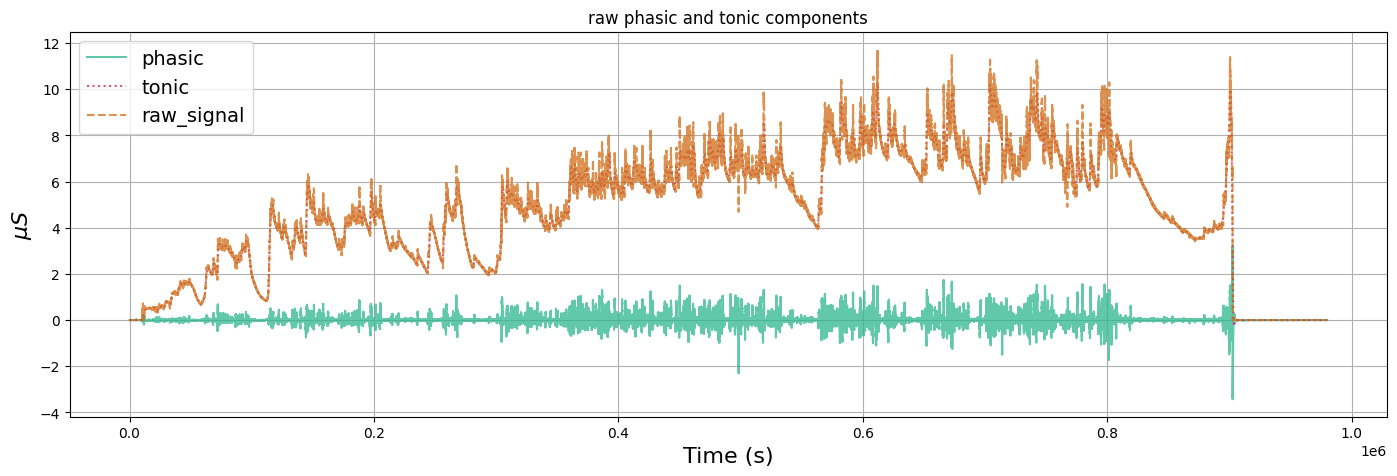

In [34]:
view_time_frame(test_subject_corrected, samp_freq=128, begin_time_s=begin_time_s, end_time_s=end_time_s, cols_to_use=['phasic', 'tonic', 'raw_signal'], img_title='raw phasic and tonic components')

In [35]:
from utilities.feature_extractors import interpolate_signals

In [36]:
test_subject_corrected_4hz = interpolate_signals(test_subject_corrected, sample_rate=128, target_hz=4)
test_subject_corrected_4hz

,time,raw_signal,clean_signal,label,auto_signal,pred_art,post_proc_pred_art,new_signal,phasic,tonic
1970-01-01 00:00:00.000,0.00,0.000000,-0.164015,0.0,2.106994e-20,1.0,1.0,-1.212401e-22,-0.000105,0.000105
1970-01-01 00:00:00.250,0.25,0.000222,0.000222,0.0,1.260593e-04,1.0,1.0,1.393272e-04,0.000028,0.000111
1970-01-01 00:00:00.500,0.50,0.000222,0.000222,0.0,2.196768e-04,0.0,0.0,2.220577e-04,0.000105,0.000117
1970-01-01 00:00:00.750,0.75,0.000222,0.000222,0.0,2.220002e-04,0.0,0.0,2.220002e-04,0.000099,0.000123
1970-01-01 00:00:01.000,1.00,0.000222,0.000222,0.0,2.220002e-04,0.0,0.0,2.220002e-04,0.000092,0.000130
...,...,...,...,...,...,...,...,...,...,...
1970-01-01 02:07:36.000,7656.00,0.000222,0.000222,0.0,2.220002e-04,0.0,0.0,2.220002e-04,0.001268,0.001020
1970-01-01 02:07:36.250,7656.25,0.000222,0.000222,0.0,2.220002e-04,0.0,0.0,2.220002e-04,0.001595,0.001020
1970-01-01 02:07:36.500,7656.50,0.000222,0.000222,0.0,2.220002e-04,0.0,0.0,2.220002e-04,0.001945,0.001020
1970-01-01 02:07:36.750,7656.75,0.000222,0.000222,0.0,2.220002e-04,0.0,0.0,2.220002e-04,0.002318,0.001020


In [37]:
test_subjects_corrected = {
    'test': [('na', test_subject_corrected_4hz)]
}

In [38]:
test_subjects_corrected_features = get_features(test_subjects_corrected, hertz=4, window_size=5)

new subject: test
n records: 30629
num_labels: 1532


c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\stress_feature_extractors.py:163: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(data[col_to_use])
c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\stress_feature_extractors.py:164: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(data[col_to_use])
c:\Users\LARRY\Documents\Scripts\thesis-writing-1\server-side\modelling\utilities\stress_feature_extractors.py:379: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  feat

In [40]:
test_subjects_corrected_features

{'test': [      raw_4hz_max  raw_4hz_min  raw_4hz_amp  raw_4hz_median   raw_4hz_std  \
  0        0.000222     0.000000     0.000211        0.000222  4.838383e-05   
  1        0.000222     0.000222     0.000222        0.000222  2.710505e-20   
  2        0.000222     0.000222     0.000222        0.000222  2.710505e-20   
  3        0.000222     0.000222     0.000222        0.000222  2.710505e-20   
  4        0.000222     0.000222     0.000222        0.000222  2.710505e-20   
  ...           ...          ...          ...             ...           ...   
  1527     0.001554     0.000222     0.000355        0.000222  3.467754e-04   
  1528     0.002886     0.000222     0.000910        0.000222  9.674218e-04   
  1529     0.003330     0.000222     0.001709        0.001332  1.500925e-03   
  1530     0.002886     0.000222     0.000888        0.000222  9.260363e-04   
  1531     0.000222     0.000222     0.000222        0.000222  0.000000e+00   
  
        raw_4hz_range  raw_4hz_shannon_en

In [39]:
test_subject_corrected_features = test_subjects_corrected_features['test'][0]
test_subject_corrected_features

,raw_4hz_max,raw_4hz_min,raw_4hz_amp,raw_4hz_median,raw_4hz_std,raw_4hz_range,raw_4hz_shannon_entropy,raw_4hz_1d_max,raw_4hz_1d_min,raw_4hz_1d_amp,...,phasic_4hz_2d_std,phasic_4hz_2d_range,phasic_4hz_2d_shannon_entropy,phasic_4hz_2d_max_abs,phasic_4hz_2d_avg_abs,raw_4hz_skewness,raw_4hz_kurt,phasic_4hz_skewness,phasic_4hz_kurt,label
0,0.000222,0.000000,0.000211,0.000222,4.838383e-05,0.000222,0.198515,0.000111,0.000111,0.000111,...,0.0,0.0,0.0,0.0,3.172701e-05,-4.129483,15.052632,-1.985440,5.304342,0.0
1,0.000222,0.000222,0.000222,0.000222,2.710505e-20,0.000000,0.000000,0.000111,0.000111,0.000111,...,0.0,0.0,0.0,0.0,2.576440e-06,NaN,NaN,0.696218,-0.744709,0.0
2,0.000222,0.000222,0.000222,0.000222,2.710505e-20,0.000000,0.000000,0.000111,0.000111,0.000111,...,0.0,0.0,0.0,0.0,3.314558e-06,NaN,NaN,0.666140,-0.950865,0.0
3,0.000222,0.000222,0.000222,0.000222,2.710505e-20,0.000000,0.000000,0.000111,0.000111,0.000111,...,0.0,0.0,0.0,0.0,1.011222e-06,NaN,NaN,-0.233372,-1.169195,0.0
4,0.000222,0.000222,0.000222,0.000222,2.710505e-20,0.000000,0.000000,0.000111,0.000111,0.000111,...,0.0,0.0,0.0,0.0,4.515816e-07,NaN,NaN,-0.190348,-1.152311,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1527,0.001554,0.000222,0.000355,0.000222,3.467754e-04,0.001332,0.587501,0.000555,0.000111,0.000153,...,0.0,0.0,0.0,0.0,3.539864e-04,2.569133,5.314163,2.552191,5.230928,0.0
1528,0.002886,0.000222,0.000910,0.000222,9.674218e-04,0.002664,1.366159,0.001443,0.000111,0.000458,...,0.0,0.0,0.0,0.0,4.282202e-04,0.990916,-0.622263,0.897924,-0.791272,0.0
1529,0.003330,0.000222,0.001709,0.001332,1.500925e-03,0.003108,1.012663,0.001665,0.000111,0.000874,...,0.0,0.0,0.0,0.0,7.693747e-04,0.046809,-1.952396,0.072373,-1.897335,0.0
1530,0.002886,0.000222,0.000888,0.000222,9.260363e-04,0.002664,1.366159,0.001221,0.000111,0.000444,...,0.0,0.0,0.0,0.0,3.927886e-04,0.942393,-0.742767,0.133933,-1.105357,0.0


In [41]:
test_subject_corrected_features.isna().sum()

raw_4hz_max                         0
raw_4hz_min                         0
raw_4hz_amp                         0
raw_4hz_median                      0
raw_4hz_std                         0
raw_4hz_range                       0
raw_4hz_shannon_entropy             0
raw_4hz_1d_max                      0
raw_4hz_1d_min                      0
raw_4hz_1d_amp                      0
raw_4hz_1d_median                1532
raw_4hz_1d_std                      0
raw_4hz_1d_range                    0
raw_4hz_1d_shannon_entropy          0
raw_4hz_1d_max_abs                  0
raw_4hz_1d_avg_abs                  0
raw_4hz_2d_max                      0
raw_4hz_2d_min                      0
raw_4hz_2d_amp                      0
raw_4hz_2d_median                1532
raw_4hz_2d_std                      0
raw_4hz_2d_range                    0
raw_4hz_2d_shannon_entropy          0
raw_4hz_2d_max_abs                  0
raw_4hz_2d_avg_abs                  0
phasic_4hz_max                      0
phasic_4hz_m

In [43]:
cols_to_remove

['raw_4hz_1d_median',
 'raw_4hz_2d_median',
 'phasic_4hz_1d_median',
 'phasic_4hz_2d_median']

# we remove the raw median and the phasic median

In [42]:
test_subject_corrected_features_cleaned = test_subject_corrected_features.drop(columns=cols_to_remove)
test_subject_corrected_features_cleaned

,raw_4hz_max,raw_4hz_min,raw_4hz_amp,raw_4hz_median,raw_4hz_std,raw_4hz_range,raw_4hz_shannon_entropy,raw_4hz_1d_max,raw_4hz_1d_min,raw_4hz_1d_amp,...,phasic_4hz_2d_std,phasic_4hz_2d_range,phasic_4hz_2d_shannon_entropy,phasic_4hz_2d_max_abs,phasic_4hz_2d_avg_abs,raw_4hz_skewness,raw_4hz_kurt,phasic_4hz_skewness,phasic_4hz_kurt,label
0,0.000222,0.000000,0.000211,0.000222,4.838383e-05,0.000222,0.198515,0.000111,0.000111,0.000111,...,0.0,0.0,0.0,0.0,3.172701e-05,-4.129483,15.052632,-1.985440,5.304342,0.0
1,0.000222,0.000222,0.000222,0.000222,2.710505e-20,0.000000,0.000000,0.000111,0.000111,0.000111,...,0.0,0.0,0.0,0.0,2.576440e-06,NaN,NaN,0.696218,-0.744709,0.0
2,0.000222,0.000222,0.000222,0.000222,2.710505e-20,0.000000,0.000000,0.000111,0.000111,0.000111,...,0.0,0.0,0.0,0.0,3.314558e-06,NaN,NaN,0.666140,-0.950865,0.0
3,0.000222,0.000222,0.000222,0.000222,2.710505e-20,0.000000,0.000000,0.000111,0.000111,0.000111,...,0.0,0.0,0.0,0.0,1.011222e-06,NaN,NaN,-0.233372,-1.169195,0.0
4,0.000222,0.000222,0.000222,0.000222,2.710505e-20,0.000000,0.000000,0.000111,0.000111,0.000111,...,0.0,0.0,0.0,0.0,4.515816e-07,NaN,NaN,-0.190348,-1.152311,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1527,0.001554,0.000222,0.000355,0.000222,3.467754e-04,0.001332,0.587501,0.000555,0.000111,0.000153,...,0.0,0.0,0.0,0.0,3.539864e-04,2.569133,5.314163,2.552191,5.230928,0.0
1528,0.002886,0.000222,0.000910,0.000222,9.674218e-04,0.002664,1.366159,0.001443,0.000111,0.000458,...,0.0,0.0,0.0,0.0,4.282202e-04,0.990916,-0.622263,0.897924,-0.791272,0.0
1529,0.003330,0.000222,0.001709,0.001332,1.500925e-03,0.003108,1.012663,0.001665,0.000111,0.000874,...,0.0,0.0,0.0,0.0,7.693747e-04,0.046809,-1.952396,0.072373,-1.897335,0.0
1530,0.002886,0.000222,0.000888,0.000222,9.260363e-04,0.002664,1.366159,0.001221,0.000111,0.000444,...,0.0,0.0,0.0,0.0,3.927886e-04,0.942393,-0.742767,0.133933,-1.105357,0.0


In [44]:
test_subject_corrected_features_cleaned = test_subject_corrected_features_cleaned.dropna()
test_subject_corrected_features_cleaned

,raw_4hz_max,raw_4hz_min,raw_4hz_amp,raw_4hz_median,raw_4hz_std,raw_4hz_range,raw_4hz_shannon_entropy,raw_4hz_1d_max,raw_4hz_1d_min,raw_4hz_1d_amp,...,phasic_4hz_2d_std,phasic_4hz_2d_range,phasic_4hz_2d_shannon_entropy,phasic_4hz_2d_max_abs,phasic_4hz_2d_avg_abs,raw_4hz_skewness,raw_4hz_kurt,phasic_4hz_skewness,phasic_4hz_kurt,label
0,0.000222,0.000000,0.000211,0.000222,0.000048,0.000222,0.198515,0.000111,0.000111,0.000111,...,0.0,0.0,0.0,0.0,0.000032,-4.129483,15.052632,-1.985440,5.304342,0.0
8,0.029082,0.000222,0.001665,0.000222,0.006290,0.028860,0.198515,0.014541,0.000111,0.001013,...,0.0,0.0,0.0,0.0,0.000923,4.129483,15.052632,4.129482,15.052624,0.0
16,0.401154,0.000222,0.083428,0.000222,0.117277,0.400932,1.676890,0.200577,0.000111,0.044525,...,0.0,0.0,0.0,0.0,0.024260,1.305921,0.587375,1.435883,0.770871,0.0
17,0.723055,0.000222,0.292330,0.217782,0.280316,0.722833,2.458204,0.361527,0.000111,0.180195,...,0.0,0.0,0.0,0.0,0.064921,0.192279,-1.711202,-0.669593,-0.924742,0.0
18,0.341214,0.000222,0.062759,0.023532,0.092246,0.340992,2.388890,0.118659,0.000111,0.022020,...,0.0,0.0,0.0,0.0,0.080381,1.791551,2.199419,1.030516,0.204579,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526,0.003330,0.000222,0.001532,0.001110,0.001350,0.003108,1.333074,0.001665,0.000111,0.000777,...,0.0,0.0,0.0,0.0,0.000666,0.164901,-1.795098,0.159916,-1.801138,0.0
1527,0.001554,0.000222,0.000355,0.000222,0.000347,0.001332,0.587501,0.000555,0.000111,0.000153,...,0.0,0.0,0.0,0.0,0.000354,2.569133,5.314163,2.552191,5.230928,0.0
1528,0.002886,0.000222,0.000910,0.000222,0.000967,0.002664,1.366159,0.001443,0.000111,0.000458,...,0.0,0.0,0.0,0.0,0.000428,0.990916,-0.622263,0.897924,-0.791272,0.0
1529,0.003330,0.000222,0.001709,0.001332,0.001501,0.003108,1.012663,0.001665,0.000111,0.000874,...,0.0,0.0,0.0,0.0,0.000769,0.046809,-1.952396,0.072373,-1.897335,0.0


In [45]:
final_X_test = test_subject_corrected_features_cleaned.drop(columns=['label']).to_numpy()
final_Y_test = test_subject_corrected_features_cleaned['label'].to_numpy().ravel()
final_X_test.shape, final_Y_test.shape

((1516, 50), (1516,))

In [46]:
np.unique(final_Y_test, return_counts=True)

(array([0.]), array([1516], dtype=int64))

In [47]:
saved_xgb_scaler = load_model('./saved/misc/xgb_scaler.pkl')
saved_stress_detector = load_model('./saved/models/stress_detector.pkl')

In [48]:
final_X_test_scaled = saved_xgb_scaler.transform(final_X_test)
final_X_test_scaled.shape

(1516, 50)

In [49]:
final_Y_test_pred = saved_stress_detector.predict(final_X_test_scaled)
final_Y_test_pred.shape

(1516,)

In [50]:
np.unique(final_Y_test_pred, return_counts=True)

(array([0, 1, 2], dtype=int64), array([  76,  358, 1082], dtype=int64))

# Coonclusion: we used unannotated eda signals from the EDABE dataset that has already been corrected to make sure noise is removed and used it as test signals in of itself to extract features from it to use as test data for a trained stress detection model trained on annotated signals  

however if for training only this can stillbe used and removing rows because of mismatched sampling rate can still be viable

# WESAD
A Multimodal Dataset for Wearable Stress and Affect Detection
Using only data from the Empatica E4 (EDA, BVP, ACM, TEMP), and RESP from Respiban (currently)
Matthew Johnson, 2019

## Dataset Information [1]:
Data Set Information:

"WESAD is a publicly available dataset for wearable stress and affect detection. This multimodal dataset features physiological and motion data, recorded from both a wrist- and a chest-worn device, of 15 subjects during a lab study. The following sensor modalities are included: blood volume pulse, electrocardiogram, electrodermal activity, electromyogram, respiration, body temperature, and three-axis acceleration. Moreover, the dataset bridges the gap between previous lab studies on stress and emotions, by containing three different affective states (neutral, stress, amusement). In addition, self-reports of the subjects, which were obtained using several established questionnaires, are contained in the dataset. Details can be found in the dataset's readme-file, as well as in [1].

## Attribute Information:

Raw sensor data was recorded with two devices: a chest-worn device (RespiBAN) and a wrist-worn device (Empatica E4). The RespiBAN device provides the following sensor data: electrocardiogram (ECG), electrodermal activity (EDA), electromyogram (EMG), respiration, body temperature, and three-axis acceleration. All signals are sampled at 700 Hz. The Empatica E4 device provides the following sensor data: blood volume pulse (BVP, 64 Hz), electrodermal activity (EDA, 4 Hz), body temperature (4 Hz), and three-axis acceleration (32 Hz).

The dataset's readme-file contains all further details with respect to the dataset structure, data format (RespiBAN device, Empatica E4 device, synchronised data), study protocol, and the self-report questionnaires."

https://archive.ics.uci.edu/ml/datasets/WESAD+%28Wearable+Stress+and+Affect+Detection%29
Classes
Baseline condition: 20 minute period of standing/sitting reading magazines.
Amusement condition: During the amusement condition, the subjects watched a set of eleven funny video clips.
Stress condition: Trier Social Stress Test (TSST), consisting of public speaking and mental arithmetic.

# References
[1] Schmidt, Philip & Reiss, Attila & Duerichen, Robert & Marberger, Claus & Van Laerhoven, Kristof. (2018). Introducing WESAD, a Multimodal Dataset for Wearable Stress and Affect Detection. 400-408. 10.1145/3242969.3242985. https://dl.acm.org/citation.cfm?doid=3242969.3242985

[2] A Greco, G Valenza, A Lanata, EP Scilingo, and L Citi "cvxEDA: a Convex Optimization Approach to Electrodermal Activity Processing" IEEE Transactions on Biomedical Engineering, 2015 DOI: 10.1109/TBME.2015.2474131 https://github.com/lciti/cvxEDA

[3] J. Choi, B. Ahmed, and R. Gutierrez-Osuna. 2012. Development and evaluation of an ambulatory stress monitor based on wearable sensors. IEEE Transactions on Information Technology in Biomedicine 16, 2 (2012).
http://research.cs.tamu.edu/prism/publications/choi2011ambulatoryStressMonitor.pdf

[6] J. Healey and R. Picard. 2005. Detecting stress during real-world driving tasks using physiological sensors. IEEE Transactions on Intelligent Transportation Systems 6, 2 (2005), 156–166.

Useful Resources:
https://github.com/jaganjag/stress_affect_detection
https://github.com/arsen-movsesyan/springboard_WESAD
https://www.birmingham.ac.uk/Documents/college-les/psych/saal/guide-electrodermal-activity.pdf
http://research.cs.tamu.edu/prism/publications/choi2011ambulatoryStressMonitor.pdf

In [273]:

# # E4 (wrist) Sampling Frequencies

# """contain the sampling frequencies/rate/hertz of each signals"""
# fs_dict = {'ACC': 32, 'BVP': 64, 'EDA': 4, 'TEMP': 4, 'label': 700, 'Resp': 700}

# WINDOW_IN_SECONDS = 30
# label_dict = {'baseline': 1, 'stress': 2, 'amusement': 0}
# int_to_label = {1: 'baseline', 2: 'stress', 0: 'amusement'}
# feat_names = None
# savePath = './data'
# subject_feature_path = '/Stress Detection Data'

# if not os.path.exists(savePath):
#     os.makedirs(savePath)
# if not os.path.exists(savePath + subject_feature_path):
#     os.makedirs(savePath + subject_feature_path)

# # cvxEDA
# def eda_stats(y):
#     Fs = fs_dict['EDA']
#     yn = (y - y.mean()) / y.std()
#     [r, p, t, l, d, e, obj] = cvxEDA.cvxEDA(yn, 1. / Fs)
#     return [r, p, t, l, d, e, obj]


# class SubjectData:

#     def __init__(self, main_path, subject_number):
#         self.name = f'S{subject_number}'
#         self.subject_keys = ['signal', 'label', 'subject']
#         self.signal_keys = ['chest', 'wrist']
#         self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
#         self.wrist_keys = ['ACC', 'BVP', 'EDA', 'TEMP']

#         # ./data/WESAD/{2-17}/{2-17}.pkl is the main path
#         with open(os.path.join(main_path, self.name) + '/' + self.name + '.pkl', 'rb') as file:
#             self.data = pickle.load(file, encoding='latin1')
#         self.labels = self.data['label']

#     def get_wrist_data(self):
#         data = self.data['signal']['wrist']
#         data.update({'Resp': self.data['signal']['chest']['Resp']})
        
#         return data

#     def get_chest_data(self):
#         return self.data['signal']['chest']

#     # """function never used"""
#     # def extract_features(self):  # only wrist
#     #     results = \
#     #         {
#     #             key: get_statistics(self.get_wrist_data()[key].flatten(), self.labels, key)
#     #             for key in self.wrist_keys
#     #         }
#     #     return results


# # https://github.com/MITMediaLabAffectiveComputing/eda-explorer/blob/master/load_files.py
# def butter_lowpass(cutoff, fs, order=5):
#     # Filtering Helper functions
#     nyq = 0.5 * fs
#     normal_cutoff = cutoff / nyq
#     b, a = scisig.butter(order, normal_cutoff, btype='low', analog=False)
#     return b, a


# def butter_lowpass_filter(data, cutoff, fs, order=5):
#     # Filtering Helper functions
#     b, a = butter_lowpass(cutoff, fs, order=order)
#     y = scisig.lfilter(b, a, data)
#     return y

# def get_slope(series):
#     linreg = scipy.stats.linregress(np.arange(len(series)), series )
#     slope = linreg[0]
#     return slope

# def get_window_stats(data, label=-1):
#     mean_features = np.mean(data)
#     std_features = np.std(data)
#     min_features = np.amin(data)
#     max_features = np.amax(data)

#     features = {'mean': mean_features, 'std': std_features, 'min': min_features, 'max': max_features,
#                 'label': label}
#     return features


# def get_net_accel(data):
#     return (data['ACC_x'] ** 2 + data['ACC_y'] ** 2 + data['ACC_z'] ** 2).apply(lambda x: np.sqrt(x))


# def get_peak_freq(x):
#     f, Pxx = scisig.periodogram(x, fs=8)
#     psd_dict = {amp: freq for amp, freq in zip(Pxx, f)}
#     peak_freq = psd_dict[max(psd_dict.keys())]
#     return peak_freq


# # https://github.com/MITMediaLabAffectiveComputing/eda-explorer/blob/master/AccelerometerFeatureExtractionScript.py
# def filterSignalFIR(eda, cutoff=0.4, numtaps=64):
#     f = cutoff / (fs_dict['ACC'] / 2.0)
#     FIR_coeff = scisig.firwin(numtaps, f)

#     return scisig.lfilter(FIR_coeff, 1, eda)


# def compute_features(e4_data_dict, labels, norm_type=None):
#     # Dataframes for each sensor type
#     """EDA from the e4 data dict is what I need"""
#     """EDA IS A (m, 1) numpy array"""
#     print(f'eda shape: {e4_data_dict['EDA'].shape}')
#     eda_df = pd.DataFrame(e4_data_dict['EDA'], columns=['EDA'])
#     bvp_df = pd.DataFrame(e4_data_dict['BVP'], columns=['BVP'])

#     print(f'ACC shape: {e4_data_dict['ACC'].shape}')
#     acc_df = pd.DataFrame(e4_data_dict['ACC'], columns=['ACC_x', 'ACC_y', 'ACC_z'])
#     temp_df = pd.DataFrame(e4_data_dict['TEMP'], columns=['TEMP'])

#     """I also need the label"""
#     print(f'labels shape: {labels.shape}, unique: {np.unique(labels)}')
#     label_df = pd.DataFrame(labels, columns=['label'])
#     resp_df = pd.DataFrame(e4_data_dict['Resp'], columns=['Resp'])

#     """
#     eda shape: (24316, 1) this means each 4 rows is 1 second since its sampling rate was 4hz
#     ACC shape: (194528, 3) this means 
#     labels shape: (4255300,)
#     """

#     # Filter EDA
#     eda_df['EDA'] = butter_lowpass_filter(eda_df['EDA'], 1.0, fs_dict['EDA'], 6)

#     # Filter ACM
#     for _ in acc_df.columns:
#         acc_df[_] = filterSignalFIR(acc_df.values)

#     # Adding indices for combination due to differing sampling frequencies
#     """but my question is what would be the final sampling 
#     frequency of the dataframe when all these signals are combined"""
    
#     """(1 / 4) * 0 = 0
#     (1 / 4) * 1 = .25
#     (1 / 4) * 2 = 0.5
#     (1 / 4) * 3 = 0.75
#     as we can see we go from 0 to 0.75 which is four rows before it gets to 1 second
#     this is because our eda signal has been sampled at 4hz
#     ...
#     (1 / 4) * 24315 = 6078.75"""
#     eda_df.index = [(1 / fs_dict['EDA']) * i for i in range(len(eda_df))]
#     bvp_df.index = [(1 / fs_dict['BVP']) * i for i in range(len(bvp_df))]
#     acc_df.index = [(1 / fs_dict['ACC']) * i for i in range(len(acc_df))]
#     temp_df.index = [(1 / fs_dict['TEMP']) * i for i in range(len(temp_df))]
#     label_df.index = [(1 / fs_dict['label']) * i for i in range(len(label_df))]
#     resp_df.index = [(1 / fs_dict['Resp']) * i for i in range(len(resp_df))]

#     # Change indices to datetime
#     eda_df.index = pd.to_datetime(eda_df.index, unit='s')
#     bvp_df.index = pd.to_datetime(bvp_df.index, unit='s')
#     temp_df.index = pd.to_datetime(temp_df.index, unit='s')
#     acc_df.index = pd.to_datetime(acc_df.index, unit='s')
#     label_df.index = pd.to_datetime(label_df.index, unit='s')
#     resp_df.index = pd.to_datetime(resp_df.index, unit='s')

#     # New EDA features
#     """r is the phasic component of the eda signal, t is the tonic component of the eda signal"""
#     r, p, t, l, d, e, obj = eda_stats(eda_df['EDA'])
#     eda_df['EDA_phasic'] = r
#     eda_df['EDA_smna'] = p
#     eda_df['EDA_tonic'] = t
        
#     # Combined dataframe - not used yet
#     df = eda_df.join(bvp_df, how='outer')
#     df = df.join(temp_df, how='outer')
#     df = df.join(acc_df, how='outer')
#     df = df.join(resp_df, how='outer')
#     df = df.join(label_df, how='outer')
#     print(f'combined df: {df}, shape: {df.shape}')
#     """
#     what this does is combines all uneven dfs into a dataframe of
#     700hz the largest smapling freq used particularly for the labels"""
#     print(f'df label column contains null? {df['label'].isnull().sum()}')

#     """364740 rows contain na rows, backfill / bfill is used
#     which uses next valid observation to fill gap"""
#     df['label'] = df['label'].fillna(method='bfill')

#     print(f'df label column contains null? {df['label'].isnull().sum()}')
    
#     df.reset_index(drop=True, inplace=True)
#     print(f'combined final df: {df}, shape: {df.shape}')

#     """but we can create a column taht indicates the seconds in each row"""
#     print(f'uniques and counts of label: {df['label'].value_counts()}')

#     if norm_type is 'std':
#         # std norm
#         df = (df - df.mean()) / df.std()
#     elif norm_type is 'minmax':
#         # minmax norm
#         df = (df - df.min()) / (df.max() - df.min())

#     # Groupby
#     """
#     No. of Labels ==> 8 ; 
#     0 = not defined / transient
#     1 = baseline
#     2 = stress
#     3 = amusement
#     4 = meditation
#     5/6/7 = should be ignored in this dataset
#     instead of this in order to retain 700hz sampling freq we can turn instead the 4/5/6/7/ and 0 labels will be

#     ff. are value counts of each label in 700hz sampling frequency
#     0.0    2326361 for transient
#     1.0     869440 for baseline
#     4.0     583679 for meditation
#     2.0     467400 for stress
#     3.0     275120 for amusement
#     6.0      49400 should be ignored
#     7.0      48640 should be ignored

#     what we can do instead is have the dataset have some of its labels
#     combined that results in less labels that best indicate the
#     affective states of an individual

#     i.e. transience, and labels 6 and 7, can be combined to form a transient state of being
#     baseline can be a state of being
#     meditation can be a state of being
#     stress can be a state of being
#     amusement can be a state of being

#     that way we can retain still the 700hz sampling freq without removing rows or samples in the data
#     """

#     grouped = df.groupby('label')
#     baseline = grouped.get_group(1)
#     stress = grouped.get_group(2)
#     amusement = grouped.get_group(3)

#     return grouped, baseline, stress, amusement


# def get_samples(data, n_windows, label):
#     global feat_names

#     # 30 seconds
#     global WINDOW_IN_SECONDS

#     samples = []
#     # Using label freq (700 Hz) as our reference frequency due to it being the largest
#     # and thus encompassing the lesser ones in its resolution.
#     window_len = fs_dict['label'] * WINDOW_IN_SECONDS

#     for i in range(n_windows):
#         # Get window of data
#         w = data[window_len * i: window_len * (i + 1)]

#         # Add/Calc rms acc
#         # w['net_acc'] = get_net_accel(w)
#         w = pd.concat([w, get_net_accel(w)])
#         #w.columns = ['net_acc', 'ACC_x', 'ACC_y', 'ACC_z', 'BVP',
#           #           'EDA', 'EDA_phasic', 'EDA_smna', 'EDA_tonic', 'TEMP',
#             #         'label']
#         cols = list(w.columns)
#         cols[0] = 'net_acc'
#         w.columns = cols
        
#         # Calculate stats for window
#         wstats = get_window_stats(data=w, label=label)

#         # Seperating sample and label
#         x = pd.DataFrame(wstats).drop('label', axis=0)
#         y = x['label'][0]
#         x.drop('label', axis=1, inplace=True)

#         if feat_names is None:
#             feat_names = []
#             for row in x.index:
#                 for col in x.columns:
#                     """error TypeError: sequence item 0: expected str instance, int found occurs here"""
#                     feat_names.append('_'.join([str(row), str(col)]))

#         # sample df
#         wdf = pd.DataFrame(x.values.flatten()).T
#         wdf.columns = feat_names
#         wdf = pd.concat([wdf, pd.DataFrame({'label': y}, index=[0])], axis=1)
        
#         # More feats
#         wdf['BVP_peak_freq'] = get_peak_freq(w['BVP'].dropna())
#         wdf['TEMP_slope'] = get_slope(w['TEMP'].dropna())
#         samples.append(wdf)

#     return pd.concat(samples)


# def make_patient_data(subject_id):
#     global savePath
#     global WINDOW_IN_SECONDS

#     # Make subject data object for Sx
#     subject = SubjectData(main_path='./data/WESAD', subject_number=subject_id)

#     # Empatica E4 data - now with resp
#     """returns dictionary"""
#     e4_data_dict = subject.get_wrist_data()
#     print(f'{e4_data_dict}')

#     # norm type
#     norm_type = None

#     # The 3 classes we are classifying
#     print(f'subject labels: {subject.labels}, type: {type(subject.labels)}, shape: {subject.labels.shape}')
#     grouped, baseline, stress, amusement = compute_features(e4_data_dict, subject.labels, norm_type)
#     # print(f'grouped: {grouped}')
#     # print(f'grouped shape: {grouped.shape}')
#     # print(f'baseline: {baseline}')
#     print(f'baseline shape: {len(baseline)}')
#     # print(f'stress: {stress}')
#     print(f'stress shape: {len(stress)}')
#     # print(f'amusement: {amusement}')
#     print(f'amusement shape: {len(amusement)}')

#     # print(f'Available windows for {subject.name}:')
#     """label is 700hz, window in seconds is 30s
#     41
#     22
#     13
#     """
#     n_baseline_wdws = int(len(baseline) / (fs_dict['label'] * WINDOW_IN_SECONDS))
#     n_stress_wdws = int(len(stress) / (fs_dict['label'] * WINDOW_IN_SECONDS))
#     n_amusement_wdws = int(len(amusement) / (fs_dict['label'] * WINDOW_IN_SECONDS))
#     print(f'Baseline: {n_baseline_wdws}\nStress: {n_stress_wdws}\nAmusement: {n_amusement_wdws}\n')

#     #
#     baseline_samples = get_samples(baseline, n_baseline_wdws, label=1)
#     # Downsampling
#     # baseline_samples = baseline_samples[::2]
#     stress_samples = get_samples(stress, n_stress_wdws, label=2)
#     amusement_samples = get_samples(amusement, n_amusement_wdws, label=0)

#     all_samples = pd.concat([baseline_samples, stress_samples, amusement_samples])
#     all_samples = pd.concat([all_samples.drop('label', axis=1), pd.get_dummies(all_samples['label'])], axis=1)
#     # Selected Features
#     # all_samples = all_samples[['EDA_mean', 'EDA_std', 'EDA_min', 'EDA_max',
#     #                          'BVP_mean', 'BVP_std', 'BVP_min', 'BVP_max',
#     #                        'TEMP_mean', 'TEMP_std', 'TEMP_min', 'TEMP_max',
#     #                        'net_acc_mean', 'net_acc_std', 'net_acc_min', 'net_acc_max',
#     #                        0, 1, 2]]
#     # Save file as csv (for now)
#     all_samples.to_csv(f'{savePath}{subject_feature_path}/S{subject_id}_feats_4.csv')

#     # Does this save any space?
#     subject = None


# def combine_files(subjects):
#     df_list = []
#     for s in subjects:
#         df = pd.read_csv(f'{savePath}{subject_feature_path}/S{s}_feats_4.csv', index_col=0)
#         df['subject'] = s
#         df_list.append(df)

#     df = pd.concat(df_list, axis=0)
#     print(df)

#     """error ValueError: substring not found occurs in this line"""
#     # 0 is the annotation for amusement
#     # 1 is baseline 
#     # 2 is the annotation for stress
#     df['label'] = df.apply(lambda row: 0 if row['0'] == True else 1 if row['1'] == True else 2, axis=1)
#     # labels = (df['0'].astype(str) + df['1'].astype(str) + df['2'].astype(str))
#     # print(labels)
#     # # print(labels.index)
#     # df['label'] = (df['0'].astype(str) + df['1'].astype(str) + df['2'].astype(str)).apply(lambda row: row.index(0))
#     df.drop(['0', '1', '2'], axis=1, inplace=True)

#     df.reset_index(drop=True, inplace=True)
#     print(df)

#     df.to_csv(f'{savePath}{subject_feature_path}/may14_feats4.csv')

#     counts = df['label'].value_counts()
#     print('Number of samples per class:')
#     for label, number in zip(counts.index, counts.values):
#         print(f'{int_to_label[label]}: {number}')

In [274]:
# subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

# for patient in subject_ids:
#     print(f'Processing data for S{patient}...')
#     make_patient_data(patient)

# combine_files(subject_ids)
# print('Processing complete.')

In [275]:


# fs_dict = {'ACC': 32, 'BVP': 64, 'EDA': 4, 'TEMP': 4, 'label': 700, 'Resp': 700}
# WINDOW_IN_SECONDS = 30
# label_dict = {'baseline': 1, 'stress': 2, 'amusement': 0}
# int_to_label = {1: 'baseline', 2: 'stress', 0: 'amusement'}
# feat_names = None
# savePath = './data'
# subject_feature_path = '/Stress Detection Data'

# if not os.path.exists(savePath):
#     os.makedirs(savePath)
# if not os.path.exists(savePath + subject_feature_path):
#     os.makedirs(savePath + subject_feature_path)

# class SubjectData:

#     def __init__(self, main_path, subject_number):
#         self.name = f'S{subject_number}'
#         self.subject_keys = ['signal', 'label', 'subject']
#         self.signal_keys = ['chest', 'wrist']
#         self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
#         self.wrist_keys = ['ACC', 'BVP', 'EDA', 'TEMP']

#         # ./data/WESAD/{2-17}/{2-17}.pkl is the main path
#         with open(os.path.join(main_path, self.name) + '/' + self.name + '.pkl', 'rb') as file:
#             self.data = pickle.load(file, encoding='latin1')
#         self.labels = self.data['label']

#     def get_wrist_data(self):
#         data = self.data['signal']['wrist']
#         data.update({'Resp': self.data['signal']['chest']['Resp']})
        
#         return data

#     def get_chest_data(self):
#         return self.data['signal']['chest']

# def new_label_mapper(label):
#     # for transient
#     if label == 0 or label == 6 or label == 7:
#         return 0
    
#     # for baseline
#     elif label == 1:
#         return 1
    
#     # for stress
#     elif label == 2:
#         return 2
    
#     # for amusement
#     elif label == 3:
#         return 3
    
#     # for meditation
#     elif label == 4:
#         return 4

# # all functions are reversed engineered version of the above functions such that the
# # dataframe created only contains the eda signals and affective labels for stress detection
# def eda_stats(y):
#     Fs = fs_dict['EDA']
#     yn = (y - y.mean()) / y.std()
#     [r, p, t, l, d, e, obj] = cvxEDA.cvxEDA(yn, 1. / Fs)
#     return [r, p, t, l, d, e, obj]

# def compute_features(e4_data_dict, labels, norm_type=None):
#     # Dataframes for each sensor type
#     # eda shape: (24316, 1) this means each 4 rows is 1 second since its sampling rate was 4hz
#     # ACC shape: (194528, 3) this means 
#     # labels shape: (4255300,)
#     eda_df = pd.DataFrame(e4_data_dict['EDA'], columns=['EDA'])
#     label_df = pd.DataFrame(labels, columns=['label'])
#     print(f'label df shape: {label_df}')

#     # Adding indices for combination due to differing sampling frequencies
#     # (1 / 4) * 0 = 0
#     # (1 / 4) * 1 = .25
#     # (1 / 4) * 2 = 0.5
#     # (1 / 4) * 3 = 0.75
#     # as we can see we go from 0 to 0.75 which is four rows before it gets to 1 second
#     # this is because our eda signal has been sampled at 4hz
#     # ...
#     # (1 / 4) * 24315 = 6078.75
#     # eda_df.index = [(1 / fs_dict['EDA']) * i for i in range(len(eda_df))]
#     # label_df.index = [(1 / fs_dict['label']) * i for i in range(len(label_df))]

#     # # Change indices to datetime
#     # eda_df.index = pd.to_datetime(eda_df.index, unit='s')
#     # label_df.index = pd.to_datetime(label_df.index, unit='s')
        
#     # Combined dataframe - not used yet
#     # what this does is combines all uneven dfs into a dataframe of
#     # 700hz the largest smapling freq used particularly for the labels
#     df = eda_df.join(label_df, how='outer')
#     # print(f'combined df: {df}, shape: {df.shape}')
    
    
#     # print(f'combined final df: {df}, shape: {df.shape}')

#     # get number of rows of 700hz dataframe and use it to create time indeces
#     # 1000 / 700 milliseconds or 1.428571428571429 is 0.001428571428571429
#     # in seconds but in nanoseconds is 1428571.4285714289 or 0.0014285714285714289e-9
#     n_rows = df.shape[0]
#     timestamps_700s = pd.date_range(start=pd.to_datetime(0, unit='s'), periods=n_rows, freq=f'{1428571}ns')
#     df['time'] = timestamps_700s
#     df['time'] = df['time'].apply(lambda timestamp: timestamp.timestamp())

#     # 364740 rows contain null rows, backfill / bfill is used
#     # which uses next valid observation to fill gap. resulting df
#     # will not contain nulls anymore
#     df['label'] = df['label'].fillna(method='bfill')
#     df['label'] = df['label'].apply(new_label_mapper)

#     # reset index
#     df.reset_index(drop=True, inplace=True)

#     if norm_type is 'std':
#         # std norm
#         df = (df - df.mean()) / df.std()
#     elif norm_type is 'minmax':
#         # minmax norm
#         df = (df - df.min()) / (df.max() - df.min())

#     # No. of Labels ==> 8 ; 
#     # 0 = not defined / transient
#     # 1 = baseline
#     # 2 = stress
#     # 3 = amusement
#     # 4 = meditation
#     # 5/6/7 = should be ignored in this dataset
#     # instead of this in order to retain 700hz sampling freq we can turn instead the 4/5/6/7/ and 0 labels will be

#     # ff. are value counts of each label in 700hz sampling frequency
#     # 0.0    2326361 for transient
#     # 1.0     869440 for baseline
#     # 4.0     583679 for meditation
#     # 2.0     467400 for stress
#     # 3.0     275120 for amusement
#     # 6.0      49400 should be ignored
#     # 7.0      48640 should be ignored

#     # what we can do instead is have the dataset have some of its labels
#     # combined that results in less labels that best indicate the
#     # affective states of an individual

#     # i.e. transience, and labels 6 and 7, can be combined to form a transient state of being (0)
#     # baseline can be a state of being  (1)
#     # meditation can be a state of being (4)
#     # stress can be a state of being (2)
#     # amusement can be a state of being (3)

#     # that way we can retain still the 700hz sampling freq without removing rows or samples in the data
#     return df

# def make_patient_data(subject_id):
#     global savePath
#     global WINDOW_IN_SECONDS

#     # Make subject data object for Sx
#     subject = SubjectData(main_path='./data/WESAD', subject_number=subject_id)

#     # Empatica E4 data - now with resp
#     e4_data_dict = subject.get_wrist_data()
#     # print(f'{e4_data_dict}')

#     # norm type
#     norm_type = None

#     # The 3 classes we are classifying
#     # print(f'subject labels: {subject.labels}, type: {type(subject.labels)}, shape: {subject.labels.shape}')
#     df = compute_features(e4_data_dict, subject.labels, norm_type)

#     # Save file as csv (for now)
#     df.to_csv(f'{savePath}{subject_feature_path}/S{subject_id}.csv')

In [276]:
# subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

# for patient in subject_ids:
#     print(f'Processing data for S{patient}...')
#     make_patient_data(patient)

In [277]:
# from utilities.feature_extractors import interpolate_signals
# from utilities.visualizers import view_time_frame

In [278]:
# s2_700hz = pd.read_csv('./data/Stress Detection Data/S2.csv', index_col=0)
# s2_700hz

In [279]:
# end_time_s = round(s2_700hz['time'].iloc[-1])
# end_time_s * 700

In [280]:
# view_time_frame(s2_700hz, samp_freq=700, begin_time_s=0, end_time_s=end_time_s, cols_to_use=['EDA'])

In [281]:
# s2_700hz['EDA'].max()

In [282]:
# s2_700hz['EDA'].min()

In [283]:
# s2_4hz = interpolate_signals(s2_700hz, sample_rate=700, start_time=pd.to_datetime(0, unit='s'), target_hz=4)

In [284]:
# s2_4hz

In [285]:
# s2_4hz['EDA'].max()

In [286]:
# s2_4hz['EDA'].min()

In [287]:
# s2_4hz.isna().sum()

In [288]:
# s2_4hz['label'].value_counts()

In [289]:
# end_time_s = round(s2_4hz['time'].iloc[-1])
# end_time_s

In [290]:
# end_time_s * 4